Auteur : Audrey Hohmann

# Projet P5 : Notebook maintenance - simulations : Segmentez des clients d'un site e-commerce
Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation.
 
## Mission : utiliser des méthodes non supervisées pour regrouper des clients de profils similaires. 

## Data : "Brazilian E-Commerce Public Dataset by Olist" : 
Notes : 
- Une commande peut comporter plusieurs articles.
- Chaque article peut être livré par un vendeur distinct.
- Tous les textes identifiant les magasins et les partenaires ont été remplacés par les noms des grandes maisons de Game of Thrones.

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import missingno as msn
import datetime

from matplotlib import pyplot as plt

In [5]:
# pour le clusteting
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn import metrics

In [6]:
pd.options.mode.chained_assignment = None 

In [7]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Contrat de maintenance

In [8]:
df_mcommande = pd.read_csv('data_P5_mcommande.csv')

In [9]:
df_mcommande.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,credit_card,1.0,18.12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3.0,voucher,1.0,2.00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2.0,voucher,1.0,18.59,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,boleto,1.0,141.46,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,4.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,credit_card,3.0,179.12,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto,5.0


In [10]:
df_mcommande['order_purchase_timestamp'] = pd.to_datetime(df_mcommande['order_purchase_timestamp'])

In [11]:
df_mcommande_ordered = df_mcommande.sort_values('order_purchase_timestamp')

In [12]:
df_mcommande_ordered['order_purchase_date'] = df_mcommande['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')

In [13]:
df_mcommande_ordered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,order_purchase_date
108467,3b697a20d9e427646d92567910af6d57,355077684019f7f60a031656bd7262b8,delivered,2016-10-03 09:44:50,2016-10-06 15:50:54,2016-10-23 14:02:13,2016-10-26 14:02:13,2016-10-27,32ea3bdedab835c3aa6cb68ce66565ef,4106,sao paulo,SP,1.0,boleto,1.0,45.46,1,3ae08df6bcbfe23586dd431c40bddbb7,522620dcb18a6b31cd7bdf73665113a9,2016-10-21 16:27:20,29.90,15.56,relogios_presentes,63.0,1642.0,3.0,300.0,16.0,16.0,16.0,watches_gifts,4.0,2016-10-03
33111,be5bc2f0da14d8071e2d45451ad119d9,7ec40b22510fdbea1b08921dd39e63d8,delivered,2016-10-03 16:56:50,2016-10-06 16:03:44,2016-10-21 16:33:46,2016-10-27 18:19:38,2016-11-07,2f64e403852e6893ae37485d5fcacdaf,98280,panambi,RS,1.0,boleto,1.0,39.09,1,fd7fd78fd3cbc1b0a6370a7909c0a629,f09b760d23495ac9a7e00d29b769007c,2016-10-21 16:33:46,21.90,17.19,esporte_lazer,39.0,518.0,1.0,400.0,16.0,16.0,16.0,sports_leisure,4.0,2016-10-03
113950,a41c8759fbe7aab36ea07e038b2d4465,6f989332712d3222b6571b1cf5b835ce,delivered,2016-10-03 21:13:36,2016-10-05 03:11:49,2016-10-25 11:57:59,2016-11-03 10:58:07,2016-11-29,61db744d2f835035a5625b59350c6b63,90040,porto alegre,RS,1.0,boleto,1.0,53.73,1,b72b39418216e944bb34e35f4d3ea8c7,45d33f715e24d15a6ccf5c17b3a23e3c,2016-10-21 16:18:26,36.49,17.24,esporte_lazer,39.0,141.0,1.0,767.0,26.0,8.0,20.0,sports_leisure,3.0,2016-10-03
102777,d207cc272675637bfed0062edffd0818,b8cf418e97ae795672d326288dfab7a7,delivered,2016-10-03 22:06:03,2016-10-04 10:28:07,2016-10-21 14:23:37,2016-10-31 11:07:42,2016-11-23,8d3a54507421dbd2ce0a1d58046826e0,13185,hortolandia,SP,1.0,credit_card,6.0,133.46,1,107177bf61755f05c604fe57e02467d6,cca3071e3e9bb7d12640c9fbe2301306,2016-10-21 16:23:06,119.90,13.56,moveis_decoracao,55.0,130.0,1.0,2050.0,40.0,11.0,34.0,furniture_decor,1.0,2016-10-03
7784,cd3b8574c82b42fc8129f6d502690c3e,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03 22:31:31,2016-10-04 10:19:23,2016-10-08 10:34:01,2016-10-14 16:08:00,2016-11-23,87776adb449c551e74c13fc34f036105,12030,taubate,SP,1.0,credit_card,4.0,40.95,1,e2a1d45a73dc7f5a7f9236b043431b89,b499c00f28f4b7069ff6550af8c1348a,2016-10-08 10:34:01,29.99,10.96,fashion_calcados,56.0,459.0,2.0,9000.0,16.0,5.0,33.0,fashion_shoes,5.0,2016-10-03


In [14]:
time_delta = int((df_mcommande_ordered['order_purchase_timestamp'].max() - df_mcommande_ordered['order_purchase_timestamp'].min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 22 mois.


In [15]:
rfm = pd.read_csv('data_P5_RFM.csv')

## Automatisation procédure calcul RFM

In [16]:
def get_recency(df):
    # récupération de la date de la dernière commande pour identifiant unique de clients
    df_recency = df.groupby(['customer_unique_id'])['order_purchase_timestamp'].max().reset_index()

    df_recency.rename(columns = {"order_purchase_timestamp": "LastPurchaseDate"}, inplace = True)

    df_recency["LastPurchaseDate"] = df_recency["LastPurchaseDate"].dt.date

    #Utilisation de la dernière commande de l'ensemble des données comme point de référence pour calculer la récence :
    recent_date = df['order_purchase_timestamp'].dt.date.max()
    df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)

    return df_recency

In [17]:
def get_frequency(df):
    #Regroupement des données par identifiant unique de client pour calculer le nombre d'identifiants de commande uniques pour chaque client.
    frequency_df = df.groupby(["customer_unique_id"]).agg({"order_id": "nunique"}).reset_index()

    frequency_df.rename(columns = {"order_id": "Frequency"}, inplace = True)

    return frequency_df


In [18]:
def get_monetary(df):
    #somme des montants par identifiant client unique
    monetary_df = df.groupby(['customer_unique_id'])['payment_value'].sum().reset_index()

    monetary_df.rename(columns = {"payment_value": "Monetary"}, inplace = True)

    return monetary_df

In [19]:
scaler = MinMaxScaler().set_output(transform="pandas")

def generate_rfm_features(df):
    df_recency = get_recency(df)
    df_frequency = get_frequency(df)
    df_monetary = get_monetary(df)
    rfm = df_recency.merge(df_frequency, on = 'customer_unique_id') \
                .merge(df_monetary, on = 'customer_unique_id')

    rfm.drop('LastPurchaseDate', axis = 1, inplace = True)
    
    return rfm

## Solution 1 : Création des fonctions d'entraînement du modèle mini-batch Kmeans

MiniBatchKMeans est une variante de l'algorithme K-means qui fonctionne en utilisant des mini-batchs d'échantillons plutôt que l'ensemble complet de données pour effectuer les mises à jour des centres de clusters. Cela permet de réduire le temps de calcul nécessaire pour converger vers une solution.

Voici comment fonctionne l'algorithme MiniBatchKMeans de sklearn :

1. Sélectionner un nombre de centres de cluster (k) et initialiser les centres de manière aléatoire.

2. Diviser l'ensemble de données en mini-batchs de taille fixe. Le nombre de mini-batchs est généralement beaucoup plus grand que le nombre de centres de cluster.

3. Pour chaque mini-batch :

a. Assigner chaque point du mini-batch au centre de cluster le plus proche en utilisant la distance euclidienne.

b. Mettre à jour les centres de cluster en utilisant la moyenne des points assignés à chaque centre.

Répéter les étapes 2 et 3 jusqu'à convergence ou jusqu'à atteindre un nombre maximum d'itérations.

Retourner les centres de cluster finaux.

L'algorithme MiniBatchKMeans peut être plus rapide que l'algorithme K-means standard, mais il peut également être moins précis car les mises à jour des centres de cluster ne sont pas effectuées sur l'ensemble complet des données. Cependant, en pratique, MiniBatchKMeans donne souvent des résultats très similaires à K-means tout en étant beaucoup plus rapide, ce qui en fait un choix populaire pour les ensembles de données de grande taille.

In [17]:
n_centers = 3

In [260]:
def create_model(n_centers=3):
    kmeans = MiniBatchKMeans(n_clusters=n_centers, n_init="auto", reassignment_ratio=0.05)
    return kmeans

In [261]:
def retrain_model(df_rfm, model, init=False):
    cols = ['Recency', 'Frequency', 'Monetary']
    df_rfm_scale = scaler.fit_transform(df_rfm[cols])
    if init:
        model.fit(df_rfm_scale[cols])
    else:
        model.partial_fit(df_rfm_scale[cols])
    return model

In [262]:
def predict_model(df_rfm, model):
    cols = ['Recency', 'Frequency', 'Monetary']
    df_rfm_scale = scaler.fit_transform(df_rfm[cols])
    return model.predict(df_rfm_scale[cols])

## Lancement de la simulation 

In [263]:
order_purchase_date = df_mcommande_ordered['order_purchase_date'].sort_values().unique()

In [264]:
init_step = 10
order_purchase_date_step = order_purchase_date[init_step]
df_rfm = generate_rfm_features(df_mcommande_ordered[df_mcommande_ordered['order_purchase_date'] <= order_purchase_date_step])

In [265]:
order_purchase_date_step

'2017-01-06'

In [266]:
df_rfm.shape

(284, 4)

In [267]:
df_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0032c76b20340da25249092a268ce66c,92,1,144.94
1,01f156677184504063bd19739f924af1,88,1,784.80
2,0636d30c77f0f9cfad81f1c9b58c791f,90,1,971.96
3,06bdfbbe1857c3c925ec81abfb1c9666,94,1,196.27
4,0829f7df6577d5a4b65439bea701405f,94,1,267.49


In [268]:
clf = create_model(n_centers=n_centers)

In [269]:
clf = retrain_model(df_rfm, clf, init=True)

In [270]:
len(clf.labels_)

284

In [271]:
df_rfm['cluster_label'] = predict_model(df_rfm, clf)

In [272]:
pd.DataFrame(df_rfm['cluster_label'].value_counts().sort_index()).T

,0,1,2
cluster_label,41,22,221


In [273]:
df_rfm.head(3)

,customer_unique_id,Recency,Frequency,Monetary,cluster_label
0,0032c76b20340da25249092a268ce66c,92,1,144.94,2
1,01f156677184504063bd19739f924af1,88,1,784.80,0
2,0636d30c77f0f9cfad81f1c9b58c791f,90,1,971.96,0


In [274]:
clf.cluster_centers_

array([[0.9611825 , 0.01155844, 0.15153797],
       [0.00863973, 0.12260692, 0.01418184],
       [0.96359701, 0.        , 0.02369934]])

In [275]:
df_cluster_size_list = [pd.DataFrame(df_rfm['cluster_label'].value_counts().sort_index()).T]
centers_coords = [clf.cluster_centers_]
date_steps = [order_purchase_date_step]
step = 20
inertia_list = [clf.inertia_]

for ind in range(init_step + step, len(order_purchase_date), step):
    order_purchase_date_step = order_purchase_date[ind]
    print(order_purchase_date_step)
    date_steps.append(order_purchase_date_step)
    df_rfm_temp = generate_rfm_features(df_mcommande_ordered[(df_mcommande_ordered['order_purchase_date'] <= order_purchase_date_step) & 
                                                       (df_mcommande_ordered['order_purchase_date'] > order_purchase_date[ind-step])])
    print(f'Len df_rfm: {len(df_rfm)}')
    clf = retrain_model(df_rfm_temp, clf, init=False)
    df_rfm_temp['cluster_label'] = predict_model(df_rfm_temp, clf)
    df_rfm = pd.concat([df_rfm, df_rfm_temp])
    
    inertia_list.append(clf.inertia_)
   
    
    df_cluster_size_list.append(pd.DataFrame(df_rfm['cluster_label'].value_counts().sort_index()).T)
    centers_coords.append(clf.cluster_centers_.copy())

2017-01-26
Len df_rfm: 284
2017-02-15
Len df_rfm: 756
2017-03-07
Len df_rfm: 1996
2017-03-27
Len df_rfm: 3143
2017-04-16
Len df_rfm: 4818
2017-05-06
Len df_rfm: 6221
2017-05-26
Len df_rfm: 8039
2017-06-15
Len df_rfm: 10350
2017-07-05
Len df_rfm: 12573
2017-07-25
Len df_rfm: 14506
2017-08-14
Len df_rfm: 17054
2017-09-03
Len df_rfm: 19618
2017-09-23
Len df_rfm: 22266
2017-10-13
Len df_rfm: 25079
2017-11-02
Len df_rfm: 27853
2017-11-22
Len df_rfm: 30628
2017-12-12
Len df_rfm: 34023
2018-01-01
Len df_rfm: 40405
2018-01-21
Len df_rfm: 43115
2018-02-10
Len df_rfm: 47775
2018-03-02
Len df_rfm: 52179
2018-03-22
Len df_rfm: 56948
2018-04-11
Len df_rfm: 61571
2018-05-01
Len df_rfm: 65791
2018-05-21
Len df_rfm: 70344
2018-06-10
Len df_rfm: 75505
2018-06-30
Len df_rfm: 78723
2018-07-20
Len df_rfm: 82867
2018-08-09
Len df_rfm: 86395
2018-08-29
Len df_rfm: 91671


In [276]:
df_cluster_size = pd.concat(df_cluster_size_list).reset_index(drop=True)

In [277]:
df_cluster_size.head()

,0,1,2
0,41,22,221
1,66,398,292
2,81,1170,745
3,112,1873,1158
4,165,2782,1871


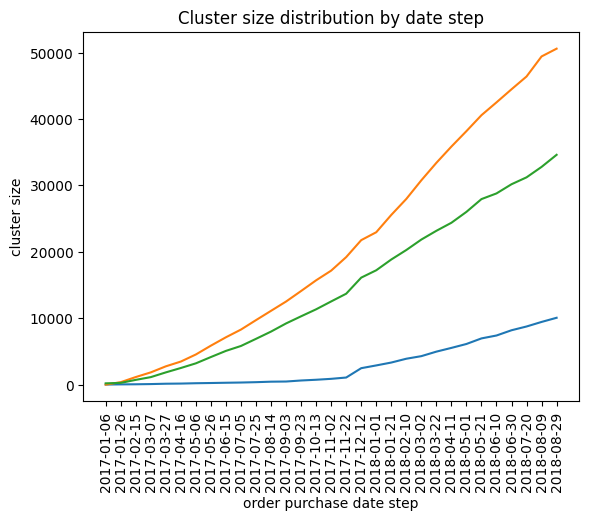

In [278]:
plt.plot(date_steps, df_cluster_size)
plt.xlabel('order purchase date step')
plt.ylabel('cluster size')
plt.xticks(rotation=90)
plt.title('Cluster size distribution by date step')
plt.show()

In [ ]:
# saut dans la taille des clusters au 12/12/2017

In [279]:
diff_centers_dict = dict()
for i in range(0, n_centers):
    diff_centers_dict[i] = []

for i in range(0,len(centers_coords) - 1):
    centers = centers_coords[i]
    next_centers = centers_coords[i+1]
    for j in range(0, n_centers):
        dist = np.linalg.norm(centers[j] - next_centers[j])
        diff_centers_dict[j].append(dist)

In [280]:
df_diff_centers = pd.DataFrame(diff_centers_dict)

In [281]:
df_diff_centers.head()

,0,1,2
0,0.109334,0.183918,0.192497
1,0.002321,0.082907,0.024297
2,0.004853,0.022252,0.012372
3,0.007425,0.021505,0.018287
4,0.001999,0.017534,0.012012


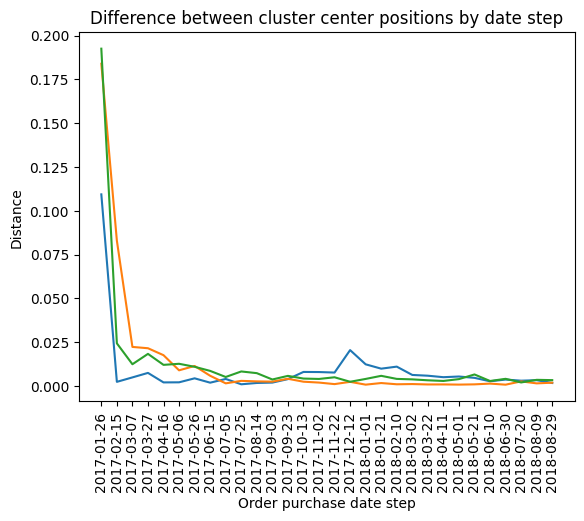

In [282]:
plt.plot(date_steps[1:], df_diff_centers)
plt.xlabel('Order purchase date step')
plt.ylabel('Distance')
plt.title('Difference between cluster center positions by date step')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# on constate une forte différence dans le centre des clusters le 12/12/2017

L'indice de stabilité temporelle (TSS) est une mesure qui permet d'évaluer la stabilité des clusters dans le temps, c'est-à-dire leur capacité à conserver la même structure au fil du temps. Pour calculer l'indice TSS, on calcule la somme des distances euclidiennes entre les centres des clusters à deux moments différents. Plus l'indice TSS est élevé, plus les clusters sont stables dans le temps.



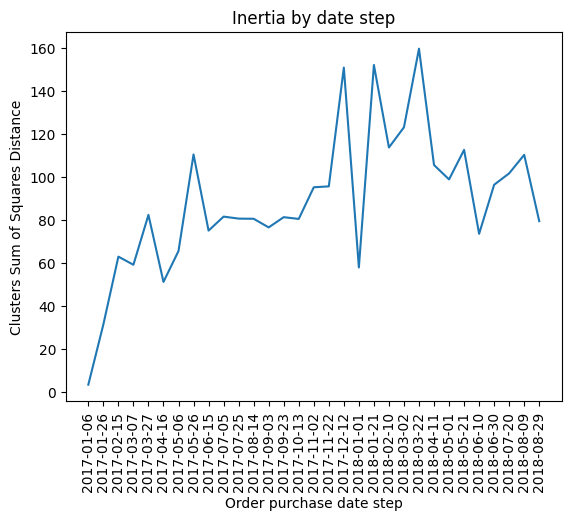

In [283]:
plt.plot(date_steps, inertia_list)
plt.xlabel('Order purchase date step')
plt.ylabel('Clusters Sum of Squares Distance')
plt.title('Inertia by date step')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# L'inertie est croissante jusqu'à atteindre un pic le 12/12/2017 avant de chuter fortement début janvier. 

## Solution 2 : Etude de l'évolution du score de l'ARI

Rand index adjusted for chance.

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

In [155]:
df_mcommande_ordered['order_purchase_timestamp'].min()

Timestamp('2016-10-03 09:44:50')

In [156]:
df_mcommande_ordered['order_purchase_timestamp'].max()

Timestamp('2018-08-29 15:00:37')

In [157]:
# Période initiale de 12 mois
data_init = df_mcommande_ordered[df_mcommande_ordered['order_purchase_date'].between("2016-10-03", "2017-10-03")]

In [158]:
data_init.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,order_purchase_date
5063,2f62dbff060e1fc79791d3f079b62769,aa9c4bc7cf8c8f30bb449b7511860ba8,delivered,2017-10-03 23:44:39,2017-10-04 00:04:10,2017-10-04 20:52:27,2017-10-10 21:47:46,2017-10-30,84394f56850c9f22ebf0013c1476cfb0,12327,jacarei,SP,1.0,debit_card,1.0,98.22,1,aede48631330269f65a8d680de491657,dbc22125167c298ef99da25668e1011f,2017-10-10 00:04:10,83.90,14.32,malas_acessorios,45.0,573.0,1.0,1400.0,48.0,10.0,33.0,luggage_accessories,5.0,2017-10-03
86236,058b47cafcb62845676917a46cf732e4,f0adbcc906e94774e167ee43ce2209f2,delivered,2017-10-03 23:52:07,2017-10-04 22:28:23,2017-10-06 19:53:18,2017-10-16 16:08:07,2017-11-01,b5b46581465f851df3529a30d2503f59,28470,santo antonio de padua,RJ,1.0,credit_card,5.0,84.20,1,b791d5d05f0c974d148d358efcd21d84,7aa4334be125fcdd2ba64b3180029f14,2017-10-10 22:28:23,25.99,16.11,cama_mesa_banho,59.0,1092.0,1.0,500.0,16.0,20.0,16.0,bed_bath_table,5.0,2017-10-03
86237,058b47cafcb62845676917a46cf732e4,f0adbcc906e94774e167ee43ce2209f2,delivered,2017-10-03 23:52:07,2017-10-04 22:28:23,2017-10-06 19:53:18,2017-10-16 16:08:07,2017-11-01,b5b46581465f851df3529a30d2503f59,28470,santo antonio de padua,RJ,1.0,credit_card,5.0,84.20,2,b791d5d05f0c974d148d358efcd21d84,7aa4334be125fcdd2ba64b3180029f14,2017-10-10 22:28:23,25.99,16.11,cama_mesa_banho,59.0,1092.0,1.0,500.0,16.0,20.0,16.0,bed_bath_table,5.0,2017-10-03
88508,9cffb1e19a2d93d7959976c5d5c11138,cd361dc0e1c92d4c4697f9af769dabfb,delivered,2017-10-03 23:54:26,2017-10-04 00:07:20,2017-10-09 18:33:27,2017-10-19 22:27:25,2017-10-27,ceae573284b9faf72e72688668cb193b,25954,teresopolis,RJ,1.0,credit_card,8.0,223.32,1,47ca911aa7f3febfc2478f63fc1aed07,dc4a0fc896dc34b0d5bfec8438291c80,2017-10-10 00:07:20,195.63,27.69,cama_mesa_banho,58.0,466.0,1.0,4200.0,60.0,25.0,40.0,bed_bath_table,5.0,2017-10-03
17864,aac83029cedfde867c3b10c7762d84cd,e0914eefae8c413678da6e1c5fbb1ca2,delivered,2017-10-03 23:55:15,2017-10-04 00:07:19,2017-10-05 15:58:13,2017-10-13 16:39:50,2017-10-31,76dd0c4744aacba27bc9e82984f9da5b,13174,sumare,SP,1.0,credit_card,2.0,133.05,1,8c591ab0ca519558779df02023177f44,a1043bafd471dff536d0c462352beb48,2017-10-10 00:07:19,99.00,34.05,ferramentas_jardim,47.0,1893.0,1.0,6050.0,20.0,20.0,20.0,garden_tools,5.0,2017-10-03


In [159]:
data_init.shape

(32604, 33)

In [160]:
# première initialisation
t0 = datetime.datetime(2017, 10, 4, 0, 0, 0)
print(t0)

2017-10-04 00:00:00


In [161]:
# Liste des périodes de mesures 
def time_range(freq):
    return pd.date_range(t0, df_mcommande_ordered['order_purchase_date'].max(), freq=freq)

In [162]:
# fonction entraînement du modèle
def train_model(df_rfm, model, scaler):
    cols = ['Recency', 'Frequency', 'Monetary']
    df_rfm_scale = scaler.transform(df_rfm[cols])
    model.fit(df_rfm_scale[cols])
    return model

In [163]:
def predict_model(df_rfm, model, scaler):
    cols = ['Recency', 'Frequency', 'Monetary']
    df_rfm_scale = scaler.transform(df_rfm[cols])
    return model.predict(df_rfm_scale[cols])

In [164]:
range1 = list(time_range('M'))
print(range1)
print(len(range1))

[Timestamp('2017-10-31 00:00:00', freq='M'), Timestamp('2017-11-30 00:00:00', freq='M'), Timestamp('2017-12-31 00:00:00', freq='M'), Timestamp('2018-01-31 00:00:00', freq='M'), Timestamp('2018-02-28 00:00:00', freq='M'), Timestamp('2018-03-31 00:00:00', freq='M'), Timestamp('2018-04-30 00:00:00', freq='M'), Timestamp('2018-05-31 00:00:00', freq='M'), Timestamp('2018-06-30 00:00:00', freq='M'), Timestamp('2018-07-31 00:00:00', freq='M')]
10


In [165]:
range1[0]

Timestamp('2017-10-31 00:00:00', freq='M')

In [166]:
len(df_mcommande_ordered[pd.to_datetime(df_mcommande_ordered['order_purchase_date']) < t0])

32604

In [167]:
kmeans = KMeans(n_clusters = 3, n_init="auto")

In [168]:
df_rfm_init = generate_rfm_features(data_init)

In [169]:
df_rfm_init.shape

(26105, 4)

In [170]:
df_rfm_init.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000f46a3911fa3c0805444483337064,207,1,86.22
1,0005e1862207bf6ccc02e4228effd9a0,213,1,150.12
2,0006fdc98a402fceb4eb0ee528f6a8d4,77,1,29.00
3,000a5ad9c4601d2bbdd9ed765d5213b3,53,1,91.28
4,000bfa1d2f1a41876493be685390d6d3,4,1,93.70


In [171]:
scaler = MinMaxScaler().set_output(transform="pandas")

In [172]:
cols = ['Recency', 'Frequency', 'Monetary']
scaler.fit(df_rfm_init[cols])

MinMaxScaler()

In [173]:
mk0 = train_model(df_rfm_init, kmeans, scaler)

In [174]:
models = [mk0]

In [175]:
len(mk0.labels_)

26105

In [176]:
df_rfm_init['C0_mk0'] = predict_model(df_rfm_init, mk0, scaler)

In [177]:
df_rfm_init.head()

,customer_unique_id,Recency,Frequency,Monetary,C0_mk0
0,0000f46a3911fa3c0805444483337064,207,1,86.22,1
1,0005e1862207bf6ccc02e4228effd9a0,213,1,150.12,1
2,0006fdc98a402fceb4eb0ee528f6a8d4,77,1,29.00,0
3,000a5ad9c4601d2bbdd9ed765d5213b3,53,1,91.28,0
4,000bfa1d2f1a41876493be685390d6d3,4,1,93.70,0


In [178]:
data_T1 = df_mcommande_ordered[pd.to_datetime(df_mcommande_ordered['order_purchase_date']) < range1[0]]

In [179]:
data_T1.shape

(37356, 33)

In [180]:
df_rfm_T1 = generate_rfm_features(data_T1)

In [181]:
df_rfm_T1.shape

(29845, 4)

In [182]:
scaler1 = MinMaxScaler().set_output(transform="pandas")

In [183]:
scaler1.fit(df_rfm_T1[cols])

MinMaxScaler()

In [184]:
mk1 = train_model(df_rfm_T1, kmeans, scaler)

In [185]:
df_rfm_T1['C1_mk0'] = predict_model(df_rfm_T1, mk0, scaler)

In [186]:
df_rfm_T1['C1_mk1'] = predict_model(df_rfm_T1, mk1, scaler)

In [187]:
ARI = metrics.adjusted_rand_score (df_rfm_T1['C1_mk0'], df_rfm_T1['C1_mk1'])

In [188]:
print(ARI)

1.0


In [189]:
ari_scores = []

In [190]:
# tous les mois
for i in range(1, len(range1)):
    print(i)
    data_T1 = df_mcommande_ordered[pd.to_datetime(df_mcommande_ordered['order_purchase_date']) < range1[i]]
    df_rfm_T1 = generate_rfm_features(data_T1)
    kmeans1 = KMeans(n_clusters = 3, n_init="auto")
    scaler1 = MinMaxScaler().set_output(transform="pandas")
    scaler1.fit(df_rfm_T1[cols])
    mk1 = train_model(df_rfm_T1, kmeans1, scaler1)
    models.append(mk1)
    df_rfm_T1['C1_mk0'] = predict_model(df_rfm_T1, mk0, scaler)
    df_rfm_T1['C1_mk1'] = predict_model(df_rfm_T1, models[i], scaler1)
    ARI = metrics.adjusted_rand_score (df_rfm_T1['C1_mk0'], df_rfm_T1['C1_mk1'])
    ari_scores.append(ARI)
    

1
2
3
4
5
6
7
8
9


In [191]:
ari_scores

[0.8942569390616456,
 0.80175499817054,
 0.6659059502346248,
 0.48961024657945434,
 0.4222609037906302,
 0.459234146512908,
 0.3912321070238443,
 0.385275764985282,
 0.39427184771797136]

In [192]:
d = {'periode': np.arange(1, 10, 1) , 'date': range1[1:10], 'ARI': ari_scores}
df_ari_scores = pd.DataFrame(data=d)

In [193]:
df_ari_scores

,periode,date,ARI
0,1,2017-11-30,0.894257
1,2,2017-12-31,0.801755
2,3,2018-01-31,0.665906
3,4,2018-02-28,0.489610
4,5,2018-03-31,0.422261
5,6,2018-04-30,0.459234
6,7,2018-05-31,0.391232
7,8,2018-06-30,0.385276
8,9,2018-07-31,0.394272


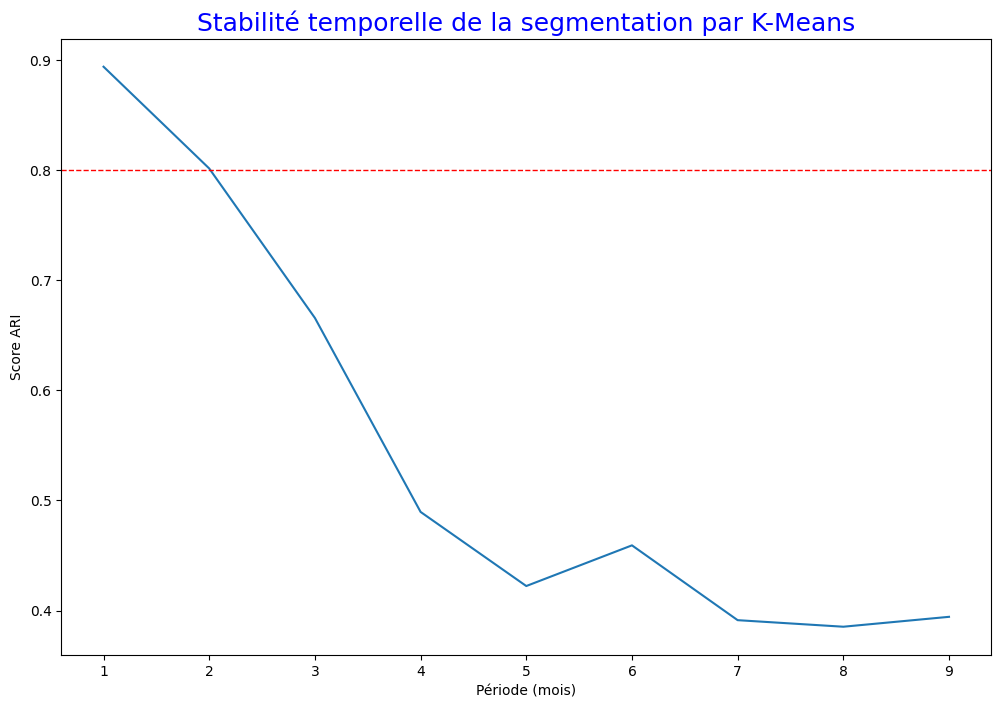

In [194]:
# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=df_ari_scores, x="periode", y="ARI")
plt.axhline(y=0.8, color='r', label='0.8', linestyle='--', linewidth=1)

plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()